<a href="https://colab.research.google.com/github/NaokiDohi/covid-19_analysis/blob/master/covid_19_forecast_with_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime as dt#デフォはUTCの国際基準時間
import pytz#日本時間に変換
import time

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import statsmodels.api as sm # version 0.8.0以上
from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_error,r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout,GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras import regularizers
from keras.models import load_model
from keras import backend as K
from keras.utils import plot_model
from IPython.display import Image

from google.colab import files

In [ ]:
path = 'COVID-19'
if not os.path.exists(path):
  !git clone https://github.com/CSSEGISandData/COVID-19.git
else:
  print("Dude!! This file is already download")
#dataの更新は21：３０に行われる？

Cloning into 'COVID-19'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 62369 (delta 4), reused 9 (delta 4), pack-reused 62357
Receiving objects: 100% (62369/62369), 528.97 MiB | 32.73 MiB/s, done.
Resolving deltas: 100% (39823/39823), done.
Checking out files: 100% (722/722), done.


2020-01-22         2
2020-01-23         2
2020-01-24         2
2020-01-25         2
2020-01-26         4
               ...  
2020-10-30    100450
2020-10-31    101327
2020-11-01    101943
2020-11-02    102431
2020-11-03    103309
Name: 151, Length: 287, dtype: int64


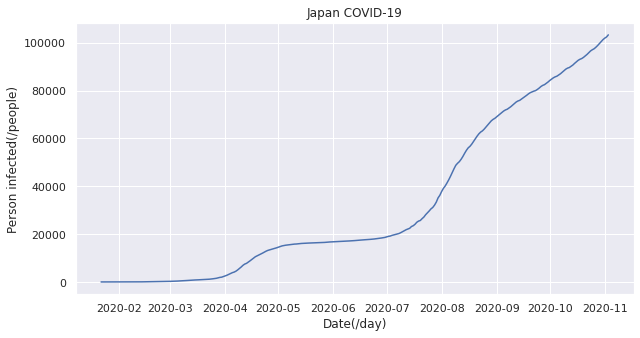

In [ ]:
df = pd.read_csv('COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df = df[df['Country/Region']=='Japan']
df = df.iloc[:,4:].copy()
data_at_japan = df.iloc[0,:]
data_at_japan.index = pd.to_datetime(data_at_japan.index)
print(data_at_japan)

plt.figure(figsize=(10,5))
plt.plot(data_at_japan)
plt.title("Japan COVID-19")
plt.xlabel("Date(/day)")
plt.ylabel("Person infected(/people)")
plt.grid(True)
plt.show()

2020-01-23      0.0
2020-01-24      0.0
2020-01-25      0.0
2020-01-26      2.0
2020-01-27      0.0
              ...  
2020-10-24    731.0
2020-10-25    496.0
2020-10-26    408.0
2020-10-27    643.0
2020-10-28    731.0
Name: 151, Length: 280, dtype: float64


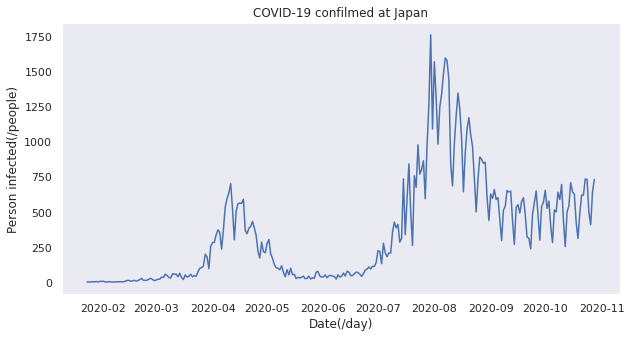

In [ ]:
data_at_japan_diff = data_at_japan - data_at_japan.shift(1) # 階差系列データの作成
data_at_japan_diff = data_at_japan_diff.dropna()
data_at_japan_diff = data_at_japan_diff['2020-01-23':'2020-10-28']
print(data_at_japan_diff)

plt.figure(figsize=(10,5))
plt.plot(data_at_japan_diff)
plt.title('COVID-19 confilmed at Japan')
plt.xlabel("Date(/day)")
plt.ylabel("Person infected(/people)")
plt.grid()
plt.show()

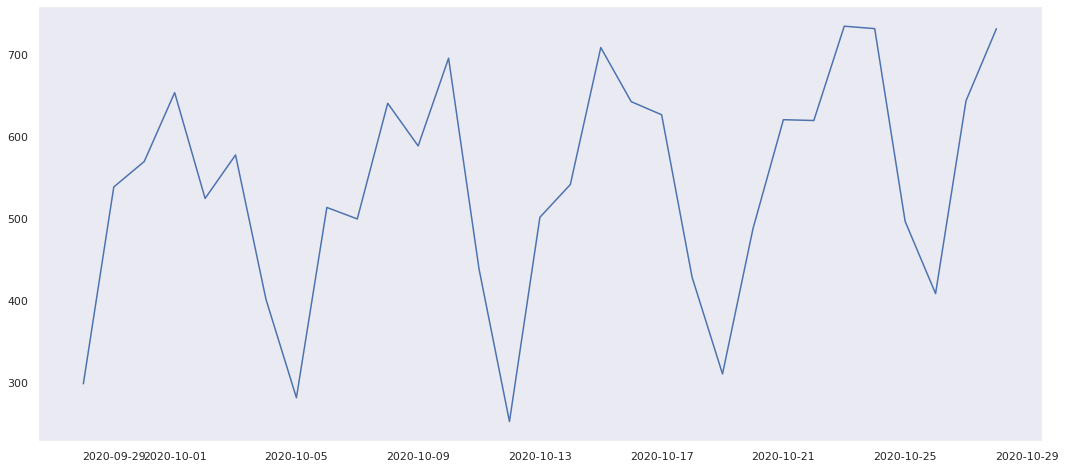

In [ ]:
hoge=data_at_japan_diff[-31:]
#print(hoge)
plt.figure(figsize=(18,8))
plt.plot(hoge)
plt.grid()
plt.show()

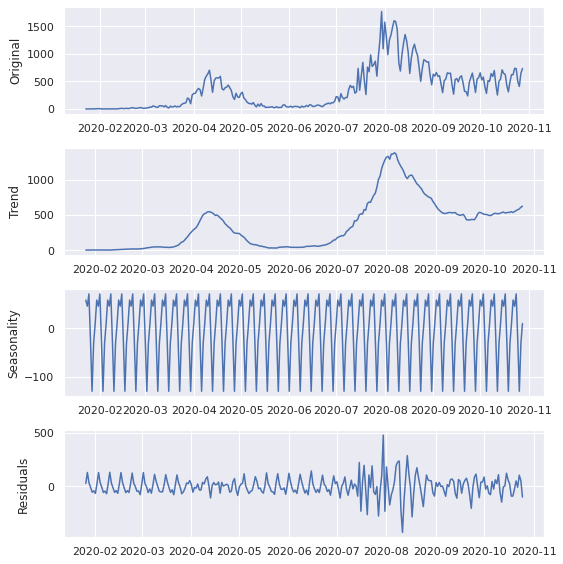

In [ ]:
res = sm.tsa.seasonal_decompose(data_at_japan_diff)#データを分解

original = data_at_japan_diff # オリジナルデータ
trend_original = res.trend # トレンドデータ
seasonal_original = res.seasonal # 季節性データ
residual = res.resid # 残差データ

plt.figure(figsize=(8, 8)) # グラフ描画枠作成、サイズ指定

# オリジナルデータのプロット
plt.subplot(411) # グラフ4行1列の1番目の位置（一番上）
plt.plot(original)
plt.ylabel('Original')

# trend データのプロット
plt.subplot(412) # グラフ4行1列の2番目の位置
plt.plot(trend_original)
plt.ylabel('Trend')

# seasonalデータ のプロット
plt.subplot(413) # グラフ4行1列の3番目の位置
plt.plot(seasonal_original)
plt.ylabel('Seasonality')

# residual データのプロット
plt.subplot(414) # グラフ4行1列の4番目の位置（一番下）
plt.plot(residual)
plt.ylabel('Residuals')

plt.tight_layout() # グラフの間隔を自動調整

In [ ]:
y = data_at_japan_diff.values.astype(float)
print(len(y))

test_size = 7
train_original_data = y[:-test_size]#0から後ろから4個目までを取り出す。　つまり学習用のデータ(学習の範囲)は直近３日間前
test_original_data = y[-test_size:]#最後から３つを取り出す。　検証用データは直近３日間前

scaler = MinMaxScaler(feature_range=(-1,1))#feature_rangeは引数に正規化変換後の最大値と最小値を決める。今回は−１から１で正規化
train_normalized = scaler.fit_transform(train_original_data.reshape(-1,1))#学習用データに正規化の適用　またskleranの入力形状に適用 合わせた行と１列

280


In [ ]:
def sequence_creator(input_data,window_size):#train_normalizedとwindow_sizeを渡し訓練データと正解ラベルを返す

    data, target = [], []
    data_len = len(input_data)
    for i in range(data_len - window_size):#data_lenのままだとwindowが配列を超えてしまう
        window_fr = input_data[i:i+window_size]#iを始点にwindow数取り出す
        correct_label = input_data[i+window_size:i+window_size+1]#index番号がi+windowの値を取り出す。つまりwindowの後にある正解ラベルを取り出す。
        data.append(window_fr)
        target.append(correct_label)

    re_data = np.array(data).reshape(len(data), window_size, 1)#kerasのRNNでは入力をサンプル数,時系列数(window数),入力層のニューロン数にする。　本来なら−１でなくlen(data)?
    re_target = np.array(target).reshape(len(target), 1)#入力と同じにする必要がある。

    return re_data, re_target

window = 7#学習時のウィンドウサイズ
study_data, correct_data  = sequence_creator(train_normalized, window)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 8)                 264       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________
None


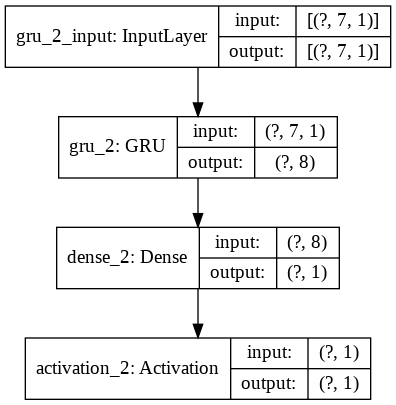

In [ ]:
n_in_out = 1
n_hidden = 8#2の乗数 128#256 #512

def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

model = Sequential()
model.add(GRU(n_hidden, batch_input_shape=(None, window, n_in_out), return_sequences=False,))#activation='relu',kernel_initializer='he_normal'))
#,kernel_regularizer=regularizers.l1(0.01)
#model.add(Dropout(0.2))
model.add(Dense(n_in_out))
model.add(Activation("linear"))
optimizer = Adam(lr=0.001,  amsgrad=True)
model.compile(loss="mse", optimizer=optimizer,metrics=["mae",rmse])# optimizer="rmsprop"
print(model.summary())

filename = 'gru.png';
plot_model(model, show_shapes=True, show_layer_names=True, to_file=filename)
Image(retina=False, filename=filename)

In [ ]:
#early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=1)
# 学習率を返す関数を用意する
def lr_schedul(epoch):
    x = 0.001
    if epoch >= 300:
        x = 0.0005
    return x


lr_decay = LearningRateScheduler(
    lr_schedul,
    # verbose=1で、更新メッセージ表示。0の場合は表示しない
    verbose=0,
)

epochs = 700
start_time = time.time()
history = model.fit(study_data, correct_data, batch_size=1, epochs=epochs, validation_split=0.1, verbose=1, callbacks=[])#lr_decay,
print("学習時間:",time.time() - start_time)

Epoch 1/700
239/239 [==============================] - 1s 4ms/step - loss: 0.2647 - mae: 0.3987 - rmse: 0.3987 - val_loss: 0.0673 - val_mae: 0.2307 - val_rmse: 0.2307
Epoch 2/700
239/239 [==============================] - 1s 3ms/step - loss: 0.0500 - mae: 0.1457 - rmse: 0.1457 - val_loss: 0.0272 - val_mae: 0.1448 - val_rmse: 0.1448
Epoch 3/700
239/239 [==============================] - 1s 3ms/step - loss: 0.0277 - mae: 0.1023 - rmse: 0.1023 - val_loss: 0.0265 - val_mae: 0.1362 - val_rmse: 0.1362
Epoch 4/700
239/239 [==============================] - 1s 3ms/step - loss: 0.0255 - mae: 0.0956 - rmse: 0.0956 - val_loss: 0.0265 - val_mae: 0.1307 - val_rmse: 0.1307
Epoch 5/700
239/239 [==============================] - 1s 3ms/step - loss: 0.0247 - mae: 0.0939 - rmse: 0.0939 - val_loss: 0.0269 - val_mae: 0.1397 - val_rmse: 0.1397
Epoch 6/700
239/239 [==============================] - 1s 3ms/step - loss: 0.0244 - mae: 0.0929 - rmse: 0.0929 - val_loss: 0.0271 - val_mae: 0.1438 - val_rmse: 0.143

In [ ]:
# model.save('covid19_gru_model.h5')
# files.download('covid19_gru_model.h5')

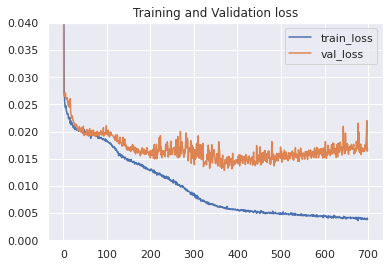

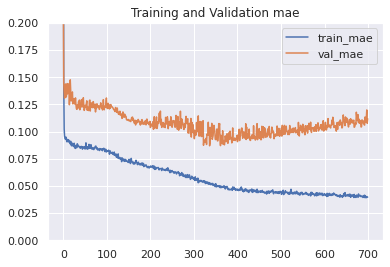

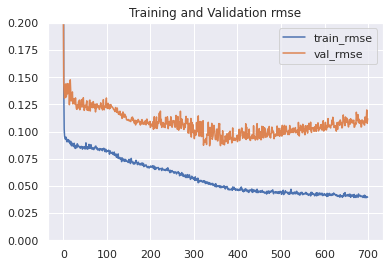

In [31]:
# === 学習推移の可視化 ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(train_loss)), train_loss, label="train_loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="val_loss")
plt.title('Training and Validation loss')
plt.ylim((0, 0.04))#add
plt.legend()
plt.show()

train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(np.arange(len(train_mae)), train_mae, label="train_mae")
plt.plot(np.arange(len(val_mae)), val_mae, label="val_mae")
plt.title('Training and Validation mae')
plt.ylim((0, 0.2))#add
plt.legend()
plt.show()

train_rmse = history.history['rmse']
val_rmse = history.history['val_rmse']

plt.plot(np.arange(len(train_loss)), train_rmse, label="train_rmse")
plt.plot(np.arange(len(val_loss)), val_rmse, label="val_rmse")
plt.title('Training and Validation rmse')
plt.ylim((0, 0.2))#add
plt.legend()
plt.show()

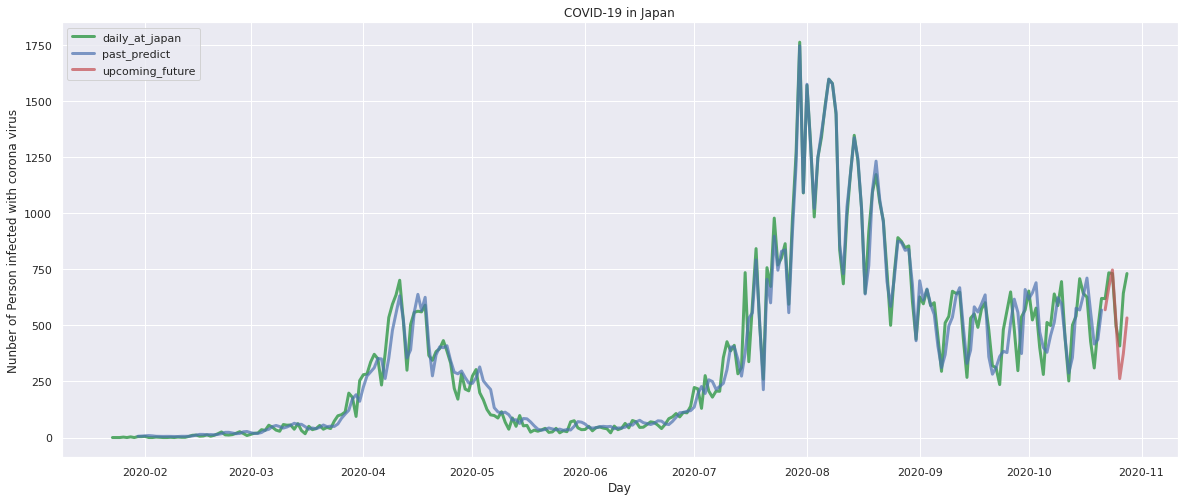

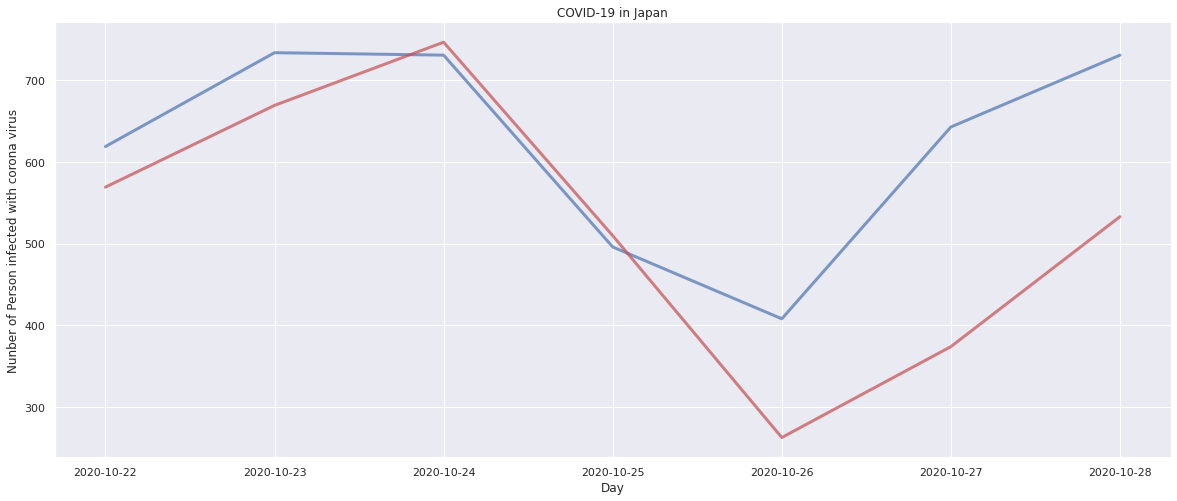

In [32]:
#training predictions
predicted_past_data = model.predict(study_data)
train_inverse= scaler.inverse_transform(predicted_past_data)

#test predictions
upcoming_future=7
predictions = train_normalized[-window:].tolist()
predictions = np.array(predictions).reshape(-1, window, 1)
#予測をfor文で
for i in range(upcoming_future):
  predicted_future = model.predict(predictions)
  with open("in_out.txt",mode="a", encoding= "utf-8") as f:
    f.write("input to model:" + str(predictions) )
    f.write("output from model:" + str(predicted_future) )
  #predictions = predictions.tolist()
  predictions = np.append(predictions,predicted_future)
  predictions = predictions[-window:]
  predictions = np.array(predictions).reshape(-1, window, 1)

predictions_infected_pepole = scaler.inverse_transform(np.array(predictions).reshape(-1,1))
#print(predictions_infected_pepole)

x_all =np.arange('2020-01-23','2020-10-29', dtype='datetime64[D]').astype('datetime64[D]')
x_past_predict = np.arange('2020-01-30','2020-10-22', dtype='datetime64[D]').astype('datetime64[D]')#23-26
x_train = np.arange('2020-01-23','2020-10-22', dtype='datetime64[D]').astype('datetime64[D]')
x_test = np.arange('2020-10-22', '2020-10-29', dtype='datetime64[D]').astype('datetime64[D]')

sns.set()
COVID = plt.figure(figsize=(20,8))
plt.title("COVID-19 in Japan")
plt.grid(True)
plt.xlabel("Day")
plt.ylabel("Nunber of Person infected with corona virus")
plt.plot(x_all,data_at_japan_diff,'g',lw=3,label='daily_at_japan')
#plt.plot(x_train,train_original_data,label='train_data')
#plt.plot(x_test,test_original_data,label='test_data')
plt.plot(x_past_predict,train_inverse,color='b', ls='-',lw=3,alpha=0.7, label='past_predict')#+8かも
plt.plot(x_test, predictions_infected_pepole, 'r',lw=3,alpha=0.7,label='upcoming_future')
plt.legend(loc='upper left')
plt.show()

sns.set()
COVID = plt.figure(figsize=(20,8))
plt.title("COVID-19 in Japan")
plt.grid(True)
plt.xlabel("Day")
plt.ylabel("Nunber of Person infected with corona virus")
plt.plot(x_test,test_original_data,color='b', ls='-',lw=3,alpha=0.7, label='past_predict')
plt.plot(x_test, predictions_infected_pepole, 'r',lw=3,alpha=0.7,label='upcoming_future')
plt.show()

In [33]:
train_data = train_original_data[7:]
train_mae = mean_absolute_error(train_data, train_inverse)
train_mse = mean_squared_error(train_data, train_inverse)
train_rmse = np.sqrt(mean_squared_error(train_data, train_inverse))
train_r2 = r2_score(train_data, train_inverse)

test_mae = mean_absolute_error(test_original_data, predictions_infected_pepole)
test_mse = mean_squared_error(test_original_data, predictions_infected_pepole)
test_rmse = np.sqrt(mean_squared_error(test_original_data, predictions_infected_pepole))
test_r2 = r2_score(test_original_data, predictions_infected_pepole)

print('train_mae:'+str(train_mae))
print('train_mse:'+str(train_mse))
print('train_rmae:'+str(train_rmse))
print('train_r2:'+str(train_r2))
print('')
print('test_mae:'+str(test_mae))
print('test_mae:'+str(test_mse))
print('test_mae:'+str(test_rmse))
print('test_mae:'+str(test_r2))#r2 最も当てはまりの良い場合、1.0 となります (当てはまりの悪い場合、マイナスとなることもあります)

train_mae:39.84915057160801
train_mse:3913.8364483567316
train_rmae:62.56066214768456
train_r2:0.9722936954262534

test_mae:108.06979128292629
test_mae:19975.39918091789
test_mae:141.33435244454157
test_mae:-0.42074190176240456


30日間後


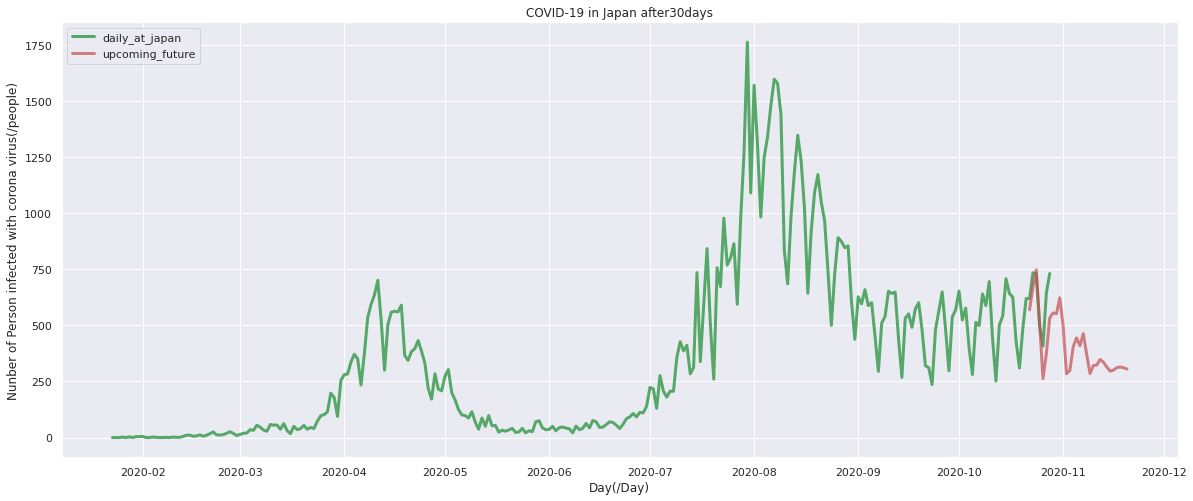

In [34]:
#long term predictions
x_long_term = np.arange('2020-10-22', '2020-11-21', dtype='datetime64[D]').astype('datetime64[D]')#11-21
long_term_future = len(x_long_term)
print(str(long_term_future) + '日間後')

predictions2 = train_normalized[-window:].tolist()
predictions2 = np.array(predictions2).reshape(-1, window, 1)

long_term_predictions = []
#予測をfor文で
for i in range(long_term_future):
  predicted_long_term_future = model.predict(predictions2)
  long_term_predictions.append(predicted_long_term_future)
  # with open("in_out_long_term.txt",mode="a", encoding= "utf-8") as f:
  #   f.write("input to model:" + str(predictions) )
  #   f.write("output from model:" + str(predicted_future) )
  #predictions2 = predictions2.tolist()
  predictions2 = np.append(predictions2, predicted_long_term_future)
  predictions2 = predictions2[-window:]
  predictions2 = np.array(predictions2).reshape(-1, window, 1)

predictions_infected_pepole_long_term = scaler.inverse_transform(np.array(long_term_predictions).reshape(-1,1))
#print(predictions_infected_pepole_long_term)


sns.set()
COVID = plt.figure(figsize=(20,8))
plt.title("COVID-19 in Japan after" + str(long_term_future) + 'days')
plt.grid(True)
plt.xlabel("Day(/Day)")
plt.ylabel("Nunber of Person infected with corona virus(/people)")
plt.plot(x_all,data_at_japan_diff,'g',lw=3,label='daily_at_japan')
plt.plot(x_long_term, predictions_infected_pepole_long_term, 'r',lw=3,alpha=0.7,label='upcoming_future')
plt.legend(loc='upper left')
plt.show()